<a href="https://colab.research.google.com/github/babakkeshavarz/time_series/blob/main/VARMA_Econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.tsa.api as VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


In [3]:
!wget https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

--2023-07-25 14:10:44--  https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76805 (75K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘us_macro_quarterly.xlsx’

us_macro_quarterly. 100%[===================>]  75.00K  --.-KB/s    in 0.007s  

2023-07-25 14:10:44 (10.1 MB/s) - ‘us_macro_quarterly.xlsx’ saved [76805/76805]



In [4]:
df = pd.read_excel('us_macro_quarterly.xlsx')
df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [5]:
def parse_date(data):
  year , quarter = data.split(':')
  month = (int(quarter) - 1) * 3 + 1
  s = f"{year}-{month}"
  return datetime.strptime(s , '%Y-%m')

In [6]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [7]:
list(df)

['Unnamed: 0',
 'GDPC96',
 'JAPAN_IP',
 'PCECTPI',
 'GS10',
 'GS1',
 'TB3MS',
 'UNRATE',
 'EXUSUK',
 'CPIAUCSL',
 'Date']

In [8]:
df.set_index('Date' , inplace = True)
df.drop(['Unnamed: 0'] , axis = 1 , inplace = True)
df.index.freq = 'QS'

<Axes: xlabel='Date'>

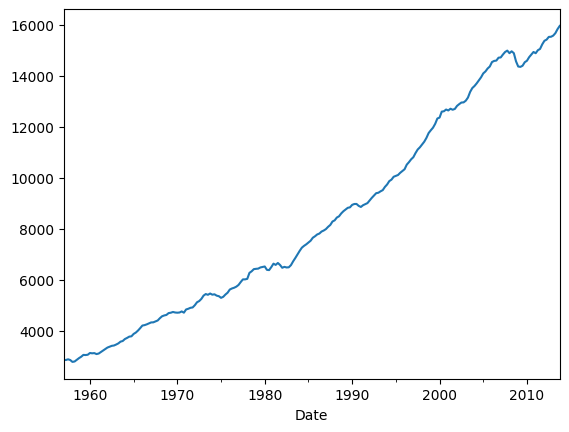

In [9]:
df['GDPC96'].plot()

In [10]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()

In [11]:
df['TSpread'] = df['GS10'] -df['TB3MS']

In [12]:
cols =['GDPGrowth' , 'TSpread']
df1 = df.iloc[1:][cols].copy()

##Granger Test##

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_result = grangercausalitytests(df1 , maxlag = 18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=6.2612  , p=0.0123  , df=1
likelihood ratio test: chi2=6.1761  , p=0.0129  , df=1
parameter F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=10.0555 , p=0.0066  , df=2
likelihood ratio test: chi2=9.8373  , p=0.0073  , df=2
parameter F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=10.6710 , p=0.0136  , df=3
likelihood ratio test: chi2=10.4246 , p=0.0153  , df=3
parameter F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8964  , p=0.0230  

In [ ]:
Ntest = 12
train = df1.iloc[:-Ntest].copy()
test = df1.iloc[-Ntest:].copy()

In [ ]:
train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

In [ ]:
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

In [ ]:
df1.loc[train_idx , :] = train
df1.loc[test_idx , :] = test


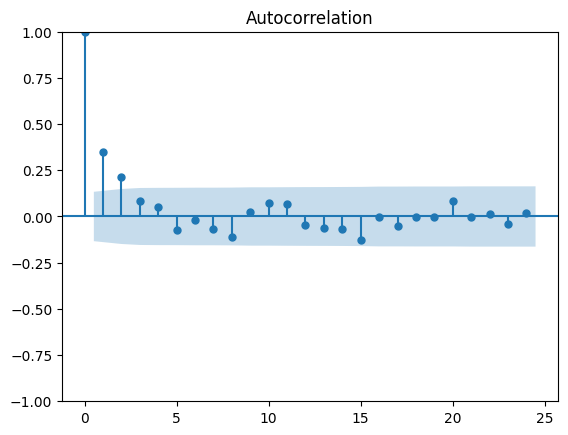

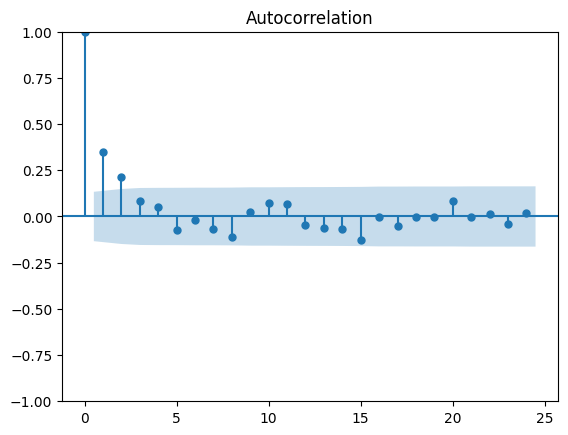

In [ ]:
plot_acf(train['GDPGrowth'])

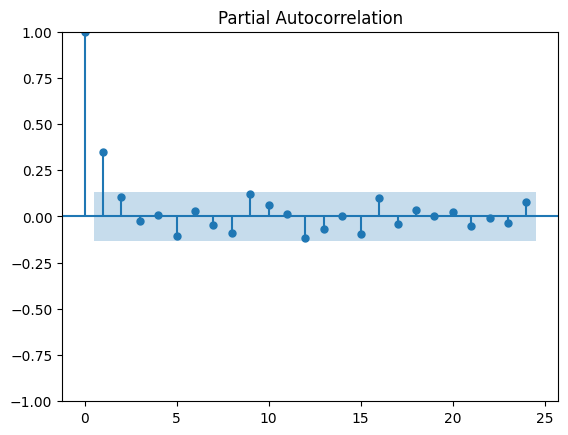

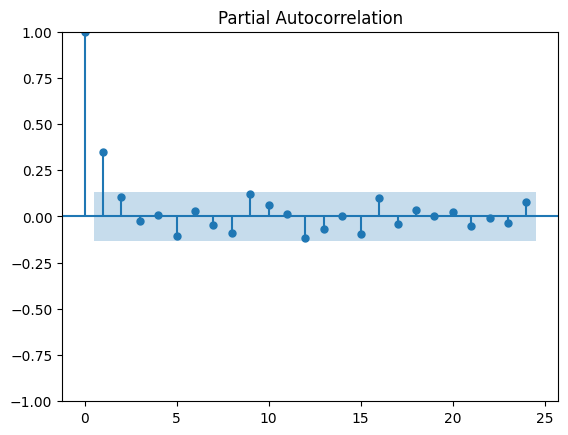

In [ ]:
plot_pacf(train['GDPGrowth'])

In [ ]:
t0 = datetime.now()
model = VARMAX(train[cols] , order = (10 , 10))
res = model.fit(maxiter = 100)
print('Duration: ' , datetime.now() - t0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration:  0:05:15.834456


In [ ]:
fcast = res.get_forecast(Ntest)


In [ ]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.008915
1972-02-01    0.835911
1972-03-01    0.717825
1972-04-01    0.818590
1972-05-01   -0.082818
                ...   
2012-04-01    0.513167
2012-05-01   -0.293116
2012-06-01   -1.064043
2012-07-01   -1.329765
2012-08-01   -1.065518
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [ ]:
joined_part.loc[train_idx, 'Train_Pred_Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test_Pred_Auckland'] = fcast.predicted_mean['ScaledAuckland']



<Axes: xlabel='Date'>

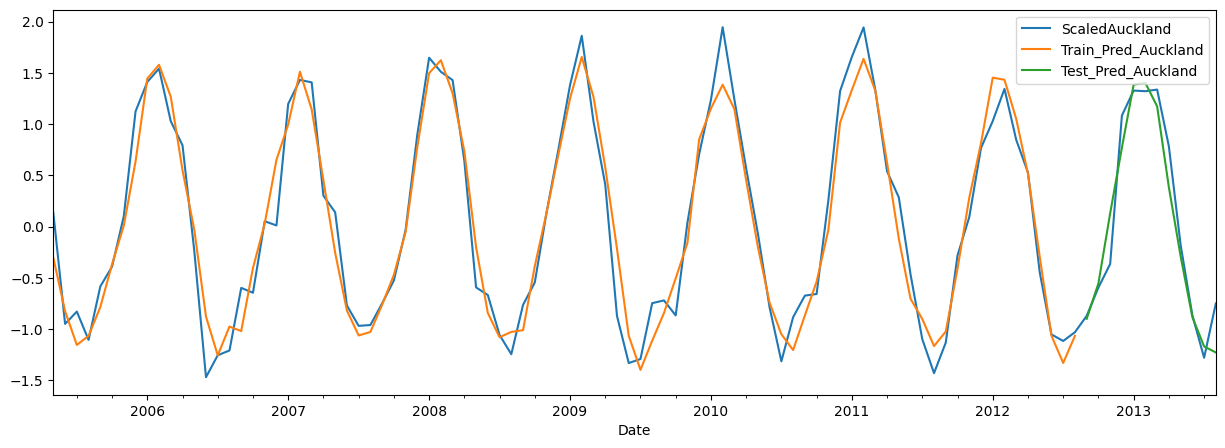

In [ ]:
plot_cols = ['ScaledAuckland' , 'Train_Pred_Auckland' , 'Test_Pred_Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize = (15,5))

In [ ]:
y_pred = joined_part.loc[train_idx , 'Train_Pred_Auckland']
y_true = joined_part.loc[train_idx , 'ScaledAuckland']
print(r2_score(y_pred, y_true))

0.9235344636343714
